# Modules

In [2]:
import sys
sys.path.append('../brian2')

In [3]:
from __future__ import division

from pylab import *
from brian2 import *
import time

from brian2.units.allunits import henry

%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'text.usetex': True})
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

# Functions

In [5]:
def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(D, N)
    return np.cos(rphase) + 1.0j * np.sin(rphase)


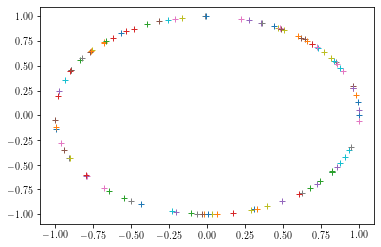

In [10]:
Z_rand=crvec(100)
plot(Z_rand.real,Z_rand.imag,'+')
show()

In [11]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [12]:
def activation_thresh(x, sigma=0.0, c_thresh=None):
    
    if c_thresh is None:
        N = x.shape[0]
        c_thresh = 2.0 / N**0.5
        
    xn = np.abs(x)
    
    a = (x ) / (np.abs(x) + 1e-12)
    a[xn < c_thresh] = 0
    
    return a

In [29]:
def cviz_im(cvec):
    ss = int(len(cvec)**0.5)
    
    ss_idx = ss**2
    
    im_cvec = np.zeros((ss, ss,3))
#     im_cvec[:,:,3]=1
    c=0
    for i in range(ss):
        for j in range(ss):
            if np.abs(cvec[c]) > 0.05:
                im_cvec[i,j,:] = matplotlib.colors.hsv_to_rgb([(np.angle(cvec[c])/2/pi + 1) % 1, 1, 1])
                
            c+=1
                
    return im_cvec
    

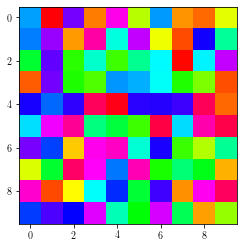

In [30]:
Z_rand=crvec(100)
imshow(cviz_im(Z_rand[0,:]))
show()

In [31]:
def phase2spikes(cv, freq=5.0):
    st = np.angle(cv) / (2*pi*freq)
    return st

# Threshold Phasor Associative Memory

## Store random sparse phasor patterns in the network

In [40]:
N=25**2 # Neurons
D=201 # Patterns
Ks=25 # Sparsity

letter_vectors_c = crvec(N, D)

for d in range(D):
    ip = np.random.choice(N, size=(N-Ks), replace=False)
    letter_vectors_c[d, ip] = 0
    
letter_vectors = 2 * (np.random.randn(D,N) < 0) - 1 # Ligne bizarre !


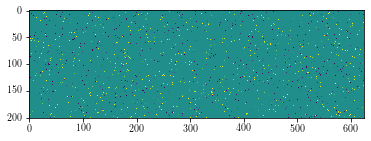

In [42]:
letter_vectors.shape
imshow(letter_vectors_c.real)

In [43]:
J_c = np.dot(letter_vectors_c.T, np.conj(letter_vectors_c))
np.fill_diagonal(J_c, 0)

In [44]:
J_c.shape

(625, 625)

## Network dynamics and simulations

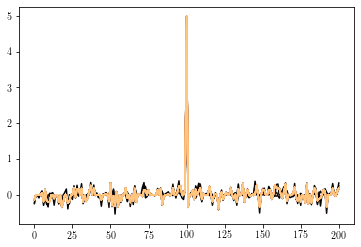

In [83]:
max_steps = 20 # Iterations
hop_hist = np.zeros((D, max_steps+1))
hop_s_hist = np.zeros((N, max_steps+1), 'complex')

target_idx = 100

hop_state_i = letter_vectors_c[target_idx,:].copy()
hop_state_i[:300] = 0 # Add JL :Partial cf fig2

noise_state = 0.05 * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
hop_state = hop_state_i + noise_state

hop_state /= norm(hop_state)

cols = get_cmap('copper', max_steps)

c_thresh = 0.6/Ks**0.5
for i in range(max_steps):
    hop_hist[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state))    
    hop_s_hist[:,i] = hop_state
    
    hop_u = np.dot(J_c, hop_state) / Ks
    hop_state = activation_thresh(hop_u, c_thresh=c_thresh )
    hop_state /= norm(hop_state)

    plot(hop_hist[:,i], c=cols(i))

hop_hist[:,i+1] =  np.real(np.dot(np.conj(letter_vectors_c), hop_state))
plot(hop_hist[:,i], c=cols(i))

In [82]:
norm(hop_state)

nan

In [74]:
hop_u = np.dot(J_c, hop_state) / Ks
norm(activation_thresh(hop_u, c_thresh=c_thresh ))
Ks

25

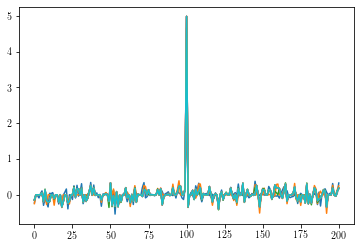

In [84]:
plot(hop_hist[:,0:10])

Text(0.5, 1.0, 'Target')

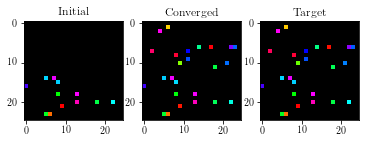

In [51]:
figure(figsize=(6,3))

subplot(131)
imshow(cviz_im(hop_state_i))
title('Initial')
subplot(132)
imshow(cviz_im(hop_s_hist[:, -2]))
title('Converged')
subplot(133)
imshow(cviz_im(letter_vectors_c[target_idx,:]))
title('Target')

## Influence of parameters (N, D, Ks)

Reproduce Figure 3 of PNAS paper

In [85]:
def generate_random_pattern(N,D,Ks):
    letter_vectors_c = crvec(N, D)

    for d in range(D):
        ip = np.random.choice(N, size=(N-Ks), replace=False)
        letter_vectors_c[d, ip] = 0
        
    return letter_vectors_c


In [86]:
def learning(letter_vectors_c):
    J_c = np.dot(letter_vectors_c.T, np.conj(letter_vectors_c))
    np.fill_diagonal(J_c, 0)
    return J_c

In [195]:
def recall(letter_vectors_c,J_c,Ks,max_steps = 20,noise_level=0.05,target_idx = 100,end=0):
    
    D=letter_vectors_c.shape[0]
    N=letter_vectors_c.shape[1]
    
    hop_hist = np.zeros((D, max_steps+1))
    hop_s_hist = np.zeros((N, max_steps+1), 'complex')
    similarity = np.zeros((max_steps,))

    hop_state_i = letter_vectors_c[target_idx,:].copy()
    hop_state_i[:end] = 0 # Add JL :Partial cf fig2

    noise_state = noise_level * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
    hop_state = hop_state_i + noise_state

    hop_state /= norm(hop_state)

    c_thresh = 0.6/Ks**0.5
    for i in range(max_steps):
        similarity[i]=np.dot(hop_state,np.conj(hop_state_i))/(norm(hop_state)*norm(hop_state_i))
        hop_hist[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state))    
        hop_s_hist[:,i] = hop_state

        hop_u = np.dot(J_c, hop_state) / Ks
        hop_state = activation_thresh(hop_u, c_thresh=c_thresh ) # JL: may be a problem with a lot of noise
        #print(hop_state[0:10])
        #print(np.sum(hop_state<0),np.sum(hop_state>0))

        hop_state /= norm(hop_state)
        
    return hop_state, hop_state_i, hop_hist, hop_s_hist, similarity

In [217]:
def average_recall(letter_vectors_c,J_c,Ks,Nsimus=100,max_steps = 20,noise_level=0.05,end=0):
    
    D=letter_vectors_c.shape[0]
    random_idx=np.random.permutation(D)
    
    if Nsimus>=D:
        Nsimus = D
        
    similarities = np.zeros((Nsimus,))
    
    for i in range(Nsimus):
        idx = random_idx[i]
        outputs = recall(letter_vectors_c,J_c,Ks,max_steps=max_steps,noise_level=noise_level,target_idx=idx,end=end)
        similarities[i] = outputs[4][-1]
        
    return similarities

In [230]:
def average_recall_with_pattern(N,Ks):
    all_D=np.int64(np.exp(np.arange(1,3,0.1)*np.log(10)))
    
    all_similarities=np.zeros((len(all_D),))
    
    for i in range(len(all_similarities)):
        letter_vectors_c=generate_random_pattern(N,D,Ks)
        J_c=learning(letter_vectors_c)
        similarities = average_recall(letter_vectors_c,J_c,Ks,Nsimus=100,max_steps = 20,noise_level=0.05,end=0)
        all_similarities[i] = np.mean(similarities)
        
    return all_similarities,all_D

## Sandbox

In [238]:
# Test of average_recall_with_pattern

N=400
Ks = 50
t1=time.time()
all_similarities,all_D = average_recall_with_pattern(N,Ks)
print(time.time()-t1)

WARNING    /home/julienlefevre/Documents/Softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
 [py.warnings]


9.33906888961792


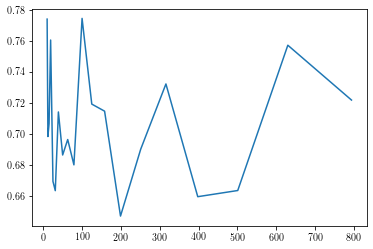

In [240]:
plot(all_D, all_similarities)

In [218]:
# Test of average_recall

similarities = average_recall(letter_vectors_c,J_c,Ks,Nsimus=100,max_steps = 20,noise_level=0.05,end=0)

WARNING    /home/julienlefevre/Documents/Softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
 [py.warnings]


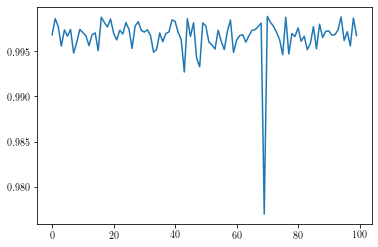

In [219]:
plot(similarities)

In [204]:
# Test of function recall

idx = 100
params = recall(letter_vectors_c,J_c,Ks,max_steps=10,noise_level=.2,target_idx=idx,end=0)
hop_state, hop_state_i, hop_hist, hop_s_hist, similarity = params

WARNING    /home/julienlefevre/Documents/Softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
 [py.warnings]


In [216]:
params[4][-1]

0.9978130319645108

Text(0.5, 1.0, 'Target')

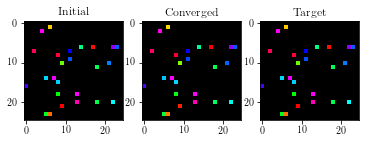

In [205]:
figure(figsize=(6,3))

subplot(131)
imshow(cviz_im(hop_state_i))
title('Initial')
subplot(132)
imshow(cviz_im(hop_s_hist[:, -2]))
title('Converged')
subplot(133)
imshow(cviz_im(letter_vectors_c[target_idx,:]))
title('Target')

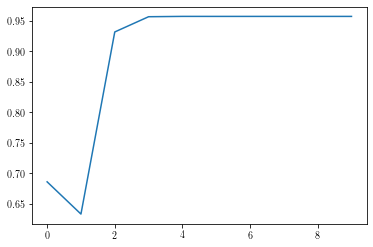

In [202]:
plot(similarity)
show()

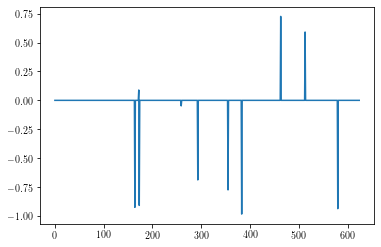

In [142]:
plot(activation_thresh(np.dot(J_c, hop_s_hist[:,0])/Ks,0.6/Ks**0.5))

In [172]:
toto=[1,2,3,4]
toto[:3]

[1, 2, 3]

In [194]:
np.corrcoef(hop_state,np.conj(hop_state_i))

array([[1.        +2.91338686e-18j, 0.12181543-1.17573816e-01j],
       [0.12181543+1.17573816e-01j, 1.        -5.31217156e-19j]])

In [229]:
np.int64(np.exp(np.arange(1,3,0.1)*np.log(10)))

array([ 10,  12,  15,  19,  25,  31,  39,  50,  63,  79, 100, 125, 158,
       199, 251, 316, 398, 501, 630, 794])